In [1]:
# load libraries and magics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import pickle
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Initial dataframe
df = pd.read_csv('supermarket_sales.csv')
df

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


**1. Preprocessing**

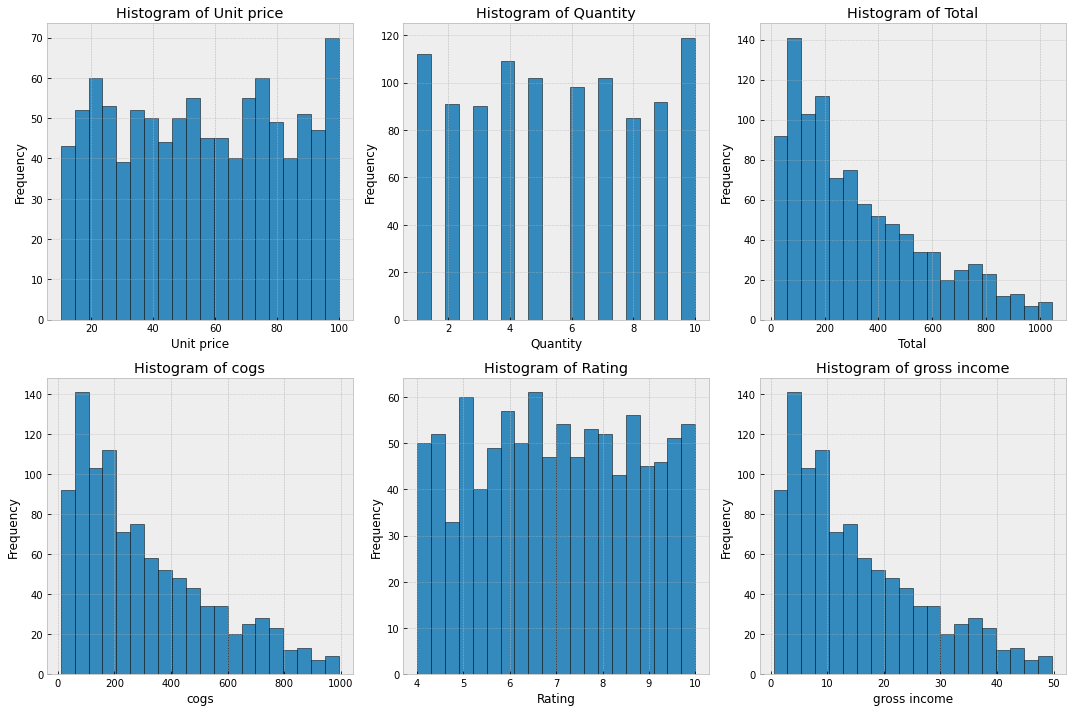

In [3]:
# Drop useless column
df = df.drop('Invoice ID', axis=1)
df = df.drop('gross margin percentage', axis=1)

# 0. Monday, 1. Tuesday, 2. Wednesday, 3. Thursday 4. Friday, 5. Saturday, 6. Sunday
day_of_week = pd.to_datetime(df['Date']).dt.day_of_week
df['Date'] = day_of_week

# 1. Morning (10:00 - 11:59), 2. Afternoon (12:00 - 16:59)
# 3. Evening (17:00 - 18:59), 4. Night (19:00 - 23:59)
hour = pd.to_datetime(df['Time']).dt.strftime('%H').astype('float')
hour_cat = pd.cut(hour, bins=[0., 12.0, 17.0, 19.0, np.inf], labels=[1, 2, 3, 4])
df['Time'] = hour_cat

# Decide which scaler we use for numeric feature
numeric_columns = ['Unit price', 'Quantity', 'Total', 'cogs', 'Rating', 'gross income']

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot histograms for each numeric column in subplots
for i, column in enumerate(numeric_columns):
    row, col = i // 3, i % 3  # Calculate the row and column for the current subplot
    axes[row, col].hist(df[column], bins=20, edgecolor='black')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

By observing we choose to use the standard scaler as the encoder for the numerical column.

**2. Gross Income**

In [4]:
# Divide features by numerical or categorical 
categorical_gi_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment']
numeric_gi_cols = ['Unit price', 'Quantity', 'Total', 'cogs', 'Rating']

# Create a ColumnTransformer to handle encoding which scales numerical and categorical data
preprocessor_gi = Pipeline([
    ('cat_num_transform', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_gi_cols),
            ('num', StandardScaler(), numeric_gi_cols)
        ]
    ))
])

This transformer can be applied to the entire task of use regression to predict gross income.

In [5]:
# Split the dataset into features and the target variable
X_gi = df.drop(columns=['gross income'])
y_gi = df['gross income']

# Split the data into training and testing sets
X_gi_train, X_gi_test, y_gi_train, y_gi_test = train_test_split(X_gi, y_gi, test_size=0.2, 
                                                               random_state=42)
X_gi_tra, X_gi_val, y_gi_tra, y_gi_val = train_test_split(X_gi_train, y_gi_train, 
                                                        test_size=0.3, random_state=42)
# Load files to test.ipynb
with open('X_gi_test.pkl', 'wb') as file:
    pickle.dump(X_gi_test, file)
with open('y_gi_test.pkl', 'wb') as file:
    pickle.dump(y_gi_test, file)

In [6]:
# Create a pipeline that includes the preprocessing and regression model without regularization
reg_gi = Pipeline([
    ('preprocessor_gi', preprocessor_gi),
    ('regressor_gi', LinearRegression())
])

# Train the regression model and load to test.ipynb
reg_gi.fit(X_gi_tra, y_gi_tra)
joblib.dump(reg_gi,'reg_gi.pkl')

['reg_gi.pkl']

In [7]:
# Get the coefficients of the Lasso regression model
reg_coeffs = reg_gi.named_steps['regressor_gi'].coef_

# Get the feature names
categorical_feature_names = preprocessor_gi.named_steps['cat_num_transform'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_gi_cols)
feature_names = list(categorical_feature_names) + numeric_gi_cols

# Create a DataFrame to display feature names and their coefficients
reg_coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': reg_coeffs})

# Filter features with non-zero coefficients
features = reg_coeffs_df[reg_coeffs_df['Coefficient'] != 0]
print("Non zero features:")
print(features)

Non zero features:
                                Feature   Coefficient
0                              Branch_A  1.127489e-05
1                              Branch_B  7.540662e-01
2                              Branch_C -2.881361e+00
3                         City_Mandalay -5.050099e+00
4                        City_Naypyitaw -1.414672e+00
5                           City_Yangon -4.296045e+00
6                  Customer type_Member  4.714645e-02
7                  Customer type_Normal  4.714645e-02
8                         Gender_Female -2.447277e-02
9                           Gender_Male -2.447277e-02
10  Product line_Electronic accessories -5.499474e-01
11     Product line_Fashion accessories -5.499474e-01
12      Product line_Food and beverages -5.499474e-01
13       Product line_Health and beauty -5.499474e-01
14      Product line_Home and lifestyle -5.499474e-01
15       Product line_Sports and travel -5.499474e-01
16                               Date_0  1.065053e+00
17       

According to the value of each coefficient, the gross income is hardly affected by Unit price (-1.614834e-15) and Quantity (-1.222877 e-15) because the coefficients of both of them are very low. The feature Total has a high positive coefficient (6.261186e+00) which means it highly affects gross income.

In [8]:
# Create a pipeline that includes the preprocessing and regression model with Lasso regularization
lasso_gi = Pipeline([
    ('preprocessor_gi', preprocessor_gi),
    ('lasso regressor_gi', Lasso())
])

# Grid search the best hyperparameter 
lambdas = [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = {'lasso regressor_gi__alpha': lambdas}
grid_search = GridSearchCV(lasso_gi, param_grid, cv=5)
grid_search.fit(X_gi_val, y_gi_val)

# Get the best lambda value
best_alpha = grid_search.best_params_['lasso regressor_gi__alpha']
print("Best Lambda Value:", best_alpha)

# Apply to model
lasso_gi = Pipeline([
    ('preprocessor_gi', preprocessor_gi),
    ('lasso regressor_gi', Lasso(alpha=best_alpha))
])

# Train the regression model with regularization and load to test.ipynb
lasso_gi.fit(X_gi_train, y_gi_train)
joblib.dump(lasso_gi,'lasso_gi.pkl')

Best Lambda Value: 0.001


['lasso_gi.pkl']

In [9]:
# Get the coefficients of the Lasso regression model
lasso_coeffs = lasso_gi.named_steps['lasso regressor_gi'].coef_

# Get the feature names
categorical_feature_names = preprocessor_gi.named_steps['cat_num_transform'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_gi_cols)
feature_names = list(categorical_feature_names) + numeric_gi_cols

# Create a DataFrame to display feature names and their coefficients
lasso_coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coeffs})

# Filter features with non-zero coefficients
features = lasso_coeffs_df[lasso_coeffs_df['Coefficient'] != 0]
print("Non zero features:")
print(features)

Non zero features:
       Feature  Coefficient
30  Unit price     0.002865
31    Quantity     0.003360
32       Total    11.577620


The non-zero coefficients of the model are only Unit price, Quantity and Total. Other features ('Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment', 'cogs', 'Rating') are all excluded.

**3. Unit Price**

In [10]:
# Divide features by numerical or categorical
categorical_up_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment']
numeric_up_cols = ['Quantity', 'Total', 'cogs', 'gross income', 'Rating']

# Create a ColumnTransformer to handle encoding which scales numerical and categorical data
preprocessor_up = Pipeline([
    ('cat_num_transform', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_up_cols),
            ('num', StandardScaler(), numeric_up_cols)
        ]
    ))
])

This transformer can be applied to the entire task of use regression to predict unit price.

In [12]:
# Split the dataset into features and the target variable
X_up = df.drop(columns=['Unit price'])
y_up = df['Unit price']

# Split the data into training and testing sets
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X_up, y_up, test_size=0.2, 
                                                                random_state=42)
X_up_tra, X_up_val, y_up_tra, y_up_val = train_test_split(X_up_train, y_up_train, test_size=0.3, 
                                                                random_state=42)
# Load test set to test.ipynb
with open('X_up_test.pkl', 'wb') as file:
    pickle.dump(X_up_test, file)
with open('y_up_test.pkl', 'wb') as file:
    pickle.dump(y_up_test, file)

In [13]:
# Create a pipeline that includes the preprocessing and regression model without regularization
reg_up = Pipeline([
    ('preprocessor_up', preprocessor_up),
    ('regressor_up', LinearRegression())
])

# Train the regression model without regularization and load to test.ipynb
reg_up.fit(X_up_tra, y_up_tra)
joblib.dump(reg_up,'reg_up.pkl')

['reg_up.pkl']

In [14]:
# Get the coefficients of the Lasso regression model
reg_coeffs = reg_up.named_steps['regressor_up'].coef_

# Get the feature names
categorical_feature_names = preprocessor_up.named_steps['cat_num_transform'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_up_cols)
feature_names = list(categorical_feature_names) + numeric_up_cols

# Create a DataFrame to display feature names and their coefficients
reg_coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': reg_coeffs})

# Filter features with non-zero coefficients
features = reg_coeffs_df[reg_coeffs_df['Coefficient'] != 0]
print("Non zero features:")
print(features)

Non zero features:
                                Feature   Coefficient
0                              Branch_A -7.630133e+10
1                              Branch_B  2.212135e+13
2                              Branch_C  5.471884e+12
3                         City_Mandalay -2.832537e+13
4                        City_Naypyitaw -1.167590e+13
5                           City_Yangon -6.127720e+12
6                  Customer type_Member  2.538695e+11
7                  Customer type_Normal  2.538695e+11
8                         Gender_Female -3.181392e+12
9                           Gender_Male -3.181392e+12
10  Product line_Electronic accessories  3.551297e+12
11     Product line_Fashion accessories  3.551297e+12
12      Product line_Food and beverages  3.551297e+12
13       Product line_Health and beauty  3.551297e+12
14      Product line_Home and lifestyle  3.551297e+12
15       Product line_Sports and travel  3.551297e+12
16                               Date_0  1.220322e+13
17       

Except for Quantity and Rating, other features have extremely high coefficients. Gross income (3.513463e+12) has a huge coefficient, while Quantity (-2.295876e+01) has a relatively low coefficient.

In [15]:
# Create a pipeline that includes the preprocessing and regression model with Lasso regularization
lasso_up = Pipeline([
    ('preprocessor_up', preprocessor_up),
    ('lasso regressor_up', Lasso())
])

# Grid search the best hyperparameter 
lambdas = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'lasso regressor_up__alpha': lambdas}
grid_search = GridSearchCV(lasso_up, param_grid, cv=5) 
grid_search.fit(X_up_val, y_up_val)

# Get the best lambda value
best_alpha = grid_search.best_params_['lasso regressor_up__alpha']
print("Best Lambda Value:", best_alpha)

# Apply to model
lasso_up = Pipeline([
    ('preprocessor_up', preprocessor_up),
    ('lasso regressor_up', Lasso(alpha=best_alpha))
])

# Train the regression model with regularization and load to test.ipynb
lasso_up.fit(X_up_train, y_up_train)
joblib.dump(lasso_up,'lasso_up.pkl')

Best Lambda Value: 1


['lasso_up.pkl']

In [16]:
# Get the coefficients of the Lasso regression model
lasso_coeffs = lasso_up.named_steps['lasso regressor_up'].coef_

# Get the feature names
categorical_feature_names = preprocessor_up.named_steps['cat_num_transform'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_up_cols)
feature_names = list(categorical_feature_names) + numeric_up_cols

# Create a DataFrame to display feature names and their coefficients
lasso_coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coeffs})

# Filter features with non-zero coefficients
features = lasso_coeffs_df[lasso_coeffs_df['Coefficient'] != 0]
print("Non-zero features:")
print(features)

Non-zero features:
     Feature  Coefficient
30  Quantity   -19.653822
31     Total    29.130228


Only Quantity and Total are retained, and the remaining features ('Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment', 'cogs', 'gross income', 'Rating' ) are excluded.

**4. Gender**

In [17]:
# Divide features by numerical or categorical 
categorical_g_cols = ['Product line', 'Payment']
numeric_g_cols = ['gross income']

# Create a ColumnTransformer to handle encoding which scales numerical and categorical data
preprocessor_g = Pipeline([
    ('cat_num_transform', ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(), categorical_g_cols),
            ('num', StandardScaler(), numeric_g_cols)
        ]
    ))
])

This transformer can be applied to the entire task of use classification to predict gender.

In [18]:
# Split the dataset into features and the target variable
df_c = df[df['Branch'] == 'C']
X_g = df_c[['Product line', 'Payment', 'gross income']] 
cat_enc = OrdinalEncoder()
y_g = cat_enc.fit_transform(df_c[['Gender']]).ravel()

# Split the data into training and testing sets
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, test_size=0.2, stratify=y_g,
                                                            random_state=42)
X_g_tra, X_g_val, y_g_tra, y_g_val = train_test_split(X_g_train, y_g_train, test_size=0.3, stratify=y_g_train,
                                                            random_state=42)
# Load test sets to test.ipynb
with open('X_g_test.pkl', 'wb') as file:
    pickle.dump(X_g_test, file)
with open('y_g_test.pkl', 'wb') as file:
    pickle.dump(y_g_test, file)
    
male = df_c[df_c['Gender'] == 'Male']
with open('male.pkl', 'wb') as file:
    pickle.dump(male, file)
    
cat_enc.categories_

[array(['Female', 'Male'], dtype=object)]

0 represent 'Female', 1 represent 'Male'

In [19]:
# Train a logistic regression model with interaction 2 degree
log_g = Pipeline([
    ('preprocessor_g', preprocessor_g),
    ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(tol=2, fit_intercept=True, random_state=42))
])
log_g.fit(X_g_tra, y_g_tra)

Pipeline(steps=[('preprocessor_g',
                 Pipeline(steps=[('cat_num_transform',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OrdinalEncoder(),
                                                                   ['Product '
                                                                    'line',
                                                                    'Payment']),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   ['gross '
                                                                    'income'])]))])),
                ('poly_feat', PolynomialFeatures(interaction_only=True)),
                ('classifier', LogisticRegression(random_state=42, tol=2))])

In [20]:
# Define hyperparameter grid for grid search
param_grid = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Grid search the best hyperparameter 
grid_search = GridSearchCV(log_g, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_g_val, y_g_val)
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
print("Best C:", best_C)

# Apply the best hyperparameters
log_g = Pipeline([
    ('preprocessor_g', preprocessor_g),
    ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(tol=2, fit_intercept=True,  
                                      C=best_C,
                                      random_state=42))
])

# Train final model and load to test.ipynb
log_g.fit(X_g_train, y_g_train)
joblib.dump(log_g,'log_g.pkl')

Best C: 0.0001


['log_g.pkl']

**5. Customer Type**

In [21]:
# Divide features by numerical or categorical 
categorical_ct_cols = ['Gender', 'Date', 'Time']

# Create a ColumnTransformer to handle encoding which scales numerical and categorical data
preprocessor_ct = Pipeline([
    ('cat_num_transform', ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(), categorical_ct_cols)
        ]
    ))
])

This transformer can be applied to the entire task of use classification to predict customer type.

In [24]:
# Split the dataset into features and the target variable
df_c = df[df['Branch'] == 'C']
X_ct = df_c[['Gender', 'Date', 'Time']] 
cat_enc = OrdinalEncoder()
y_ct = cat_enc.fit_transform(df_c[['Customer type']]).ravel()

# Split the data into training and testing sets
X_ct_train, X_ct_test, y_ct_train, y_ct_test = train_test_split(X_ct, y_ct, test_size=0.2, 
                                                            random_state=42)
X_ct_tra, X_ct_val, y_ct_tra, y_ct_val = train_test_split(X_ct_train, y_ct_train, test_size=0.3, 
                                                            random_state=42)
# Load test sets to test.ipynb
with open('X_ct_test.pkl', 'wb') as file:
    pickle.dump(X_ct_test, file)
with open('y_ct_test.pkl', 'wb') as file:
    pickle.dump(y_ct_test, file)
    
normal = df_c[df_c['Customer type'] == 'Normal']
with open('normal.pkl', 'wb') as file:
    pickle.dump(normal, file)

cat_enc.categories_

[array(['Member', 'Normal'], dtype=object)]

0 represent 'Member', 1 represent 'Normal'

In [25]:
# Train a logistic regression model with interaction 2 degree
log_ct = Pipeline([
    ('preprocessor_ct', preprocessor_ct),
    ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(tol=2, fit_intercept=True, random_state=42))
])
log_ct.fit(X_ct_tra, y_ct_tra)

Pipeline(steps=[('preprocessor_ct',
                 Pipeline(steps=[('cat_num_transform',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OrdinalEncoder(),
                                                                   ['Gender',
                                                                    'Date',
                                                                    'Time'])]))])),
                ('poly_feat', PolynomialFeatures(interaction_only=True)),
                ('classifier', LogisticRegression(random_state=42, tol=2))])

In [26]:
# Define hyperparameter grid for grid search
param_grid = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Grid search best hyperparameter
grid_search = GridSearchCV(log_ct, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_ct_val, y_ct_val)
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
print("Best C:", best_C)

# Apply the best hyperparameters
log_ct = Pipeline([
    ('preprocessor_ct', preprocessor_ct),
    ('poly_feat', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(tol=2, fit_intercept=True, 
                                      C=best_C, random_state=42))
])

# Train final model and load to test.ipynb
log_ct.fit(X_ct_train, y_ct_train)
joblib.dump(log_ct,'log_ct.pkl')

Best C: 0.0001


['log_ct.pkl']

**6. Day of purchase**

In [27]:
# Divide features by numerical or categorical 
categorical_dp_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Time', 'Payment']
numeric_dp_cols = ['Unit price', 'Quantity', 'Total', 'cogs', 'gross income', 'Rating']

# Create a ColumnTransformer to handle encoding which scales numerical and categorical data
preprocessor_dp = Pipeline([
    ('cat_num_transform', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_dp_cols),
            ('num', StandardScaler(), numeric_dp_cols)
        ]
    ))
])

This transformer can be applied to the entire task of use classification to predict day of purchase.

In [28]:
# Split the dataset into features and the target variable
cat_enc = OrdinalEncoder()
X_dp = df.drop(columns=['Date'])
y_dp = cat_enc.fit_transform(df[['Date']]).ravel()

# Split the data into training and testing sets
X_dp_train, X_dp_test, y_dp_train, y_dp_test = train_test_split(X_dp, y_dp, test_size=0.2, stratify=y_dp,
                                                            random_state=42)
X_dp_tra, X_dp_val, y_dp_tra, y_dp_val = train_test_split(X_dp_train, y_dp_train, test_size=0.3, stratify=y_dp_train,
                                                            random_state=42)
# load test sets to test.ipynb
with open('X_dp_test.pkl', 'wb') as file:
    pickle.dump(X_dp_test, file)
with open('y_dp_test.pkl', 'wb') as file:
    pickle.dump(y_dp_test, file)

cat_enc.categories_

[array([0, 1, 2, 3, 4, 5, 6])]

0 - Monday, 1 - Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday

**a. Logistic Regression**

In [29]:
# Train a logistic regression model
log_dp = Pipeline([
    ('preprocessor_dp', preprocessor_dp),
    ('classifier', LogisticRegression())
])
log_dp.fit(X_dp_tra, y_dp_tra)

Pipeline(steps=[('preprocessor_dp',
                 Pipeline(steps=[('cat_num_transform',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OneHotEncoder(),
                                                                   ['Branch',
                                                                    'City',
                                                                    'Customer '
                                                                    'type',
                                                                    'Gender',
                                                                    'Product '
                                                                    'line',
                                                                    'Time',
                                                                    'Payment']),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   ['Unit '
                                                                    'price',
                                                                    'Quantity',
                                                                    'Total',
                                                                    'cogs',
                                                                    'gross '
                                                                    'income',
                                                                    'Rating'])]))])),
                ('classifier', LogisticRegression())])

In [30]:
# Define hyperparameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__max_iter': [250, 500, 1000],
}

# Grid search best hyperparameter
grid_search = GridSearchCV(log_dp, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_dp_val, y_dp_val)
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_max_iter = best_params['classifier__max_iter']
print("Best C:", best_C)
print("Best max iter:", best_max_iter)

# Apply the best hyperparameters
log_dp = Pipeline([
    ('preprocessor_dp', preprocessor_dp),
    ('classifier', LogisticRegression(penalty='l2', C=best_C, max_iter=best_max_iter, 
                                      random_state=42))
])

# Train final model and load to test.ipynb
log_dp.fit(X_dp_train, y_dp_train)
joblib.dump(log_dp,'log_dp.pkl')

Best C: 0.001
Best max iter: 250


['log_dp.pkl']

**b. Random Forest**

In [31]:
# Train a Random forest model
rf_dp = Pipeline([
    ('preprocessor_dp', preprocessor_dp),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_dp.fit(X_dp_tra, y_dp_tra)

Pipeline(steps=[('preprocessor_dp',
                 Pipeline(steps=[('cat_num_transform',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OneHotEncoder(),
                                                                   ['Branch',
                                                                    'City',
                                                                    'Customer '
                                                                    'type',
                                                                    'Gender',
                                                                    'Product '
                                                                    'line',
                                                                    'Time',
                                                                    'Payment']),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   ['Unit '
                                                                    'price',
                                                                    'Quantity',
                                                                    'Total',
                                                                    'cogs',
                                                                    'gross '
                                                                    'income',
                                                                    'Rating'])]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [32]:
# Define hyperparameter grid for grid search
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Grid search best hyperparameter
grid_search = GridSearchCV(rf_dp, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_dp_val, y_dp_val)
best_params = grid_search.best_params_

print("Best n estimators:", best_params['classifier__n_estimators'])
print("Best criterion:", best_params['classifier__criterion'])
print("Best max depth:", best_params['classifier__max_depth'])
print("Best min samples split:", best_params['classifier__min_samples_split'])
print("Best min samples leaf:", best_params['classifier__min_samples_leaf'])

# Apply the best hyperparameters
rf_dp = Pipeline([
    ('preprocessor_dp', preprocessor_dp),
    ('classifier', RandomForestClassifier(random_state=42, 
                                          n_estimators=best_params['classifier__n_estimators'],
                                          criterion=best_params['classifier__criterion'],
                                          max_depth=best_params['classifier__max_depth'],
                                          min_samples_split=best_params['classifier__min_samples_split'],
                                          min_samples_leaf=best_params['classifier__min_samples_leaf']))
])

# Train final model and load to test.ipynb
rf_dp.fit(X_dp_train, y_dp_train)
joblib.dump(rf_dp,'rf_dp.pkl')

Best n estimators: 150
Best criterion: entropy
Best max depth: None
Best min samples split: 2
Best min samples leaf: 2


['rf_dp.pkl']